# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-12-19/data_eval_new/"
file_name = "int_norm_20161219_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [5]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [6]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [7]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

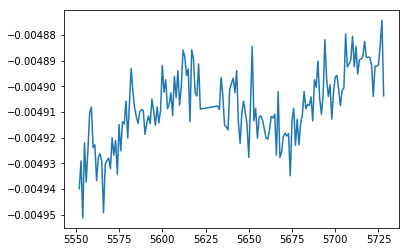

In [8]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

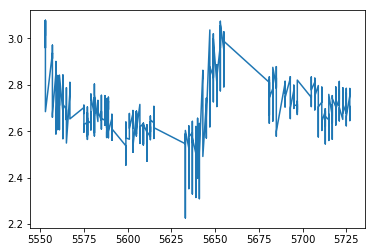

In [9]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

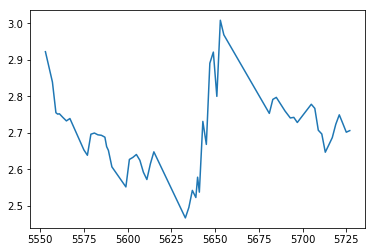

In [10]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

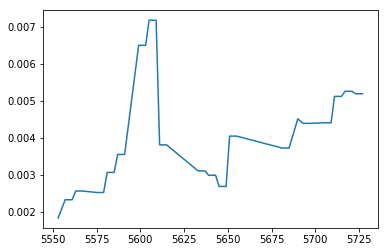

In [11]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [12]:
background_mean = df_mean(background)

# Outlier rejection

In [42]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_116_120"
interf_corr = "Te126_Xe129_corr"

In [43]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [44]:
column = "124/120"
sample = "NIST 200ppb"

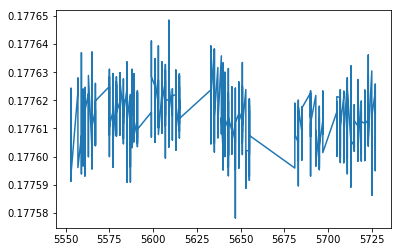

In [45]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [46]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [47]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-12-20 17:11:00,NIST 200ppb,2,1,5553,0.029832,NaN,0.010356,0.446,0.235341,0.742955,0.263520,0.142109,0.177609
2016-12-20 17:11:00,NIST 200ppb,2,2,5553,0.029824,NaN,0.010357,0.446,0.235331,0.742923,0.263504,0.142112,0.177619
2016-12-20 17:11:00,NIST 200ppb,2,3,5553,0.029827,0.020192,0.010357,NaN,0.235332,0.742928,0.263512,0.142109,0.177613
2016-12-20 17:11:00,NIST 200ppb,2,4,5553,0.029826,0.020194,0.010357,NaN,0.235343,0.742922,0.263508,0.142110,0.177612
2016-12-20 17:11:00,NIST 200ppb,2,5,5553,0.029825,0.020190,0.010359,0.446,0.235348,0.742934,0.263502,0.142104,0.177591
2016-12-20 17:11:00,NIST 200ppb,2,6,5553,0.029820,0.020187,0.010359,0.446,0.235330,0.742916,0.263530,0.142112,0.177624
2016-12-20 17:11:00,NIST 200ppb,2,7,5553,0.029824,0.020190,0.010357,0.446,0.235333,0.742930,0.263504,0.142106,0.177612
2016-12-20 17:11:00,NIST 200ppb,2,8,5553,0.029826,0.020190,0.010359,NaN,0.235351,0.742935,0.263520,0.142104,0.177608
2016-12-20 17:11:00,NIST 200ppb,2,9,5553,0.029826,0.020189,0.010358,NaN,0.235336,0.742912,0.263514,0.142112,0.177614


In [48]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
5558        2016-12-20 18:17:00    0.177140
5561        2016-12-20 19:03:00    0.187508
            2016-12-20 19:03:00    0.187570
5565        2016-12-20 20:00:00    0.187540
5581        2016-12-20 23:43:00    0.187586
5585        2016-12-21 00:41:00    0.187635
5590        2016-12-21 01:50:00    0.187651
5651        2016-12-21 16:00:00    0.187566
5655        2016-12-21 16:56:00    0.187432
5676        2016-12-21 21:51:00    0.187434
5679        2016-12-21 22:36:00    0.187358
            2016-12-21 22:36:00    0.187355
5684        2016-12-21 23:45:00    0.187401
5694        2016-12-22 02:04:00    0.187476
5707        2016-12-22 05:06:00    0.187444
5712        2016-12-22 06:15:00    0.187584
5714        2016-12-22 06:44:00    0.187648
            2016-12-22 06:44:00    0.186617
5723        2016-12-22 08:48:00    0.187568
            2016-12-22 08:48:00    0.187559
            2016-12-22 08:48:00    0.187596
5724        2016-12-22 09:02:00    0.187517


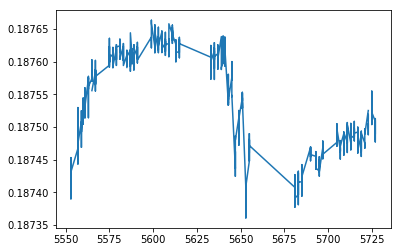

In [49]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [50]:
df[df["Sample"] == sample][column].std()

7.546694660119895e-05

In [51]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

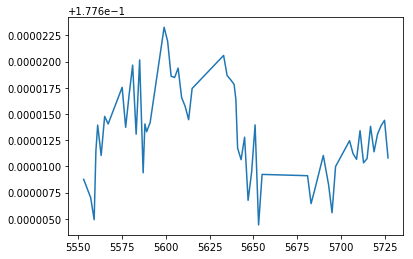

In [52]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [53]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2016-12-20 17:11:00,5553,NIST 200ppb,0.029826,0.020189,0.010359,0.446,0.235338,0.742924,0.263510,0.142108,0.177609
2016-12-20 17:37:00,5555,NIST 350ppb,0.029825,0.020190,0.010360,0.446,0.235337,0.742934,0.263511,0.142112,0.177617
2016-12-20 18:02:00,5557,NIST 200ppb,0.029825,0.020186,0.010361,0.446,0.235337,0.742915,0.263504,0.142106,0.177607
2016-12-20 18:17:00,5558,NIST 350ppb,0.029825,0.020188,0.010361,0.446,0.235335,0.742930,0.263507,0.142111,0.177617
2016-12-20 18:32:00,5559,NIST 200ppb,0.029826,0.020189,0.010361,0.446,0.235328,0.742911,0.263503,0.142104,0.177605
2016-12-20 18:48:00,5560,NIST 200ppb,0.029827,0.020191,0.010359,0.446,0.235333,0.742918,0.263504,0.142107,0.177612
2016-12-20 19:03:00,5561,NIST 200ppb,0.029825,0.020190,0.010360,0.446,0.235335,0.742918,0.263503,0.142107,0.177614
2016-12-20 19:31:00,5563,NIST 200ppb,0.029828,0.020191,0.010360,0.446,0.235333,0.742913,0.263504,0.142107,0.177611
2016-12-20 19:45:00,5564,NIST 100ppb,0.029824,0.020184,0.010362,0.446,0.235337,0.742920,0.263504,0.142110,0.177614


In [54]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [55]:
drop_sum = [pd.Timestamp("2016-12-20 17:11:00"),
            pd.Timestamp("2016-12-20 20:55:00"),
            pd.Timestamp("2016-12-21 18:46:00")]

In [56]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [57]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [58]:
data_mean_int_sum

112/120                   114/120  \
                                            mean       SD2 count      mean   
Sample                                                                       
Allende bomb 2_1                        0.029826       NaN     1  0.020193   
Indarch bomb 1_2                        0.029827       NaN     1  0.020191   
Indarch bomb 1_2 II                     0.029825       NaN     1  0.020191   
J.W. Leach 2b 1+2                       0.029823       NaN     1  0.020189   
J.W. Leach 3b+c                         0.029828       NaN     1  0.020191   
J.W. Leach 4                            0.029824       NaN     1  0.020190   
MIL09001 bomb 1_2                       0.029823       NaN     1  0.020189   
NIST 100ppb                             0.029826  0.000004    43  0.020190   
NIST 100ppb + 0.015ppb Cd + 0.08pbb Te  0.029821       NaN     1  0.020189   
NIST 200ppb                             0.029826  0.000003    58  0.020190   
NIST 200ppb + 0.005ppb U                0.029825  0.000003     2  0.020189   
NIST 200ppb + 0.01ml 1M HF              0.029824  0.000004     2  0.020190   
NIST 200ppb + 0.030ppb Cd               0.029826  0.000004     2  0.020192   
NIST 200ppb + 0.04ppb Cd                0.029828       NaN     1  0.020194   
NIST 200ppb + 0.100ppb Zr               0.029825       NaN     1  0.020188   
NIST 200ppb + 0.150ppb Rh               0.029826       NaN     1  0.020190   
NIST 200ppb + 0.250ppb Pd               0.029825  0.000005     2  0.020189   
NIST 200ppb + 0.300ppb Ru               0.029827       NaN     1  0.020189   
NIST 200ppb + 0.314ppb Te               0.029827       NaN     1  0.020192   
NIST 200ppb + 1ppb Mo                   0.029823  0.000005     2  0.020188   
NIST 200ppb + ME                        0.029828       NaN     1  0.020192   
NIST 350ppb                             0.029825  0.000003     5  0.020190   
NIST 350ppb + 0.5ml SQ                  0.029823  0.000003     2  0.020188   
ZH09-05 23.3_1_4                        0.029826       NaN     1  0.020189   
ZH09-05 23.3_3b_1                       0.029828       NaN     1  0.020193   

                                                             115/120  \
                                                 SD2 count      mean   
Sample                                                                 
Allende bomb 2_1                                 NaN     1  0.010358   
Indarch bomb 1_2                                 NaN     1  0.010359   
Indarch bomb 1_2 II                              NaN     1  0.010358   
J.W. Leach 2b 1+2                                NaN     1  0.010360   
J.W. Leach 3b+c                                  NaN     1  0.010358   
J.W. Leach 4                                     NaN     1  0.010359   
MIL09001 bomb 1_2                                NaN     1  0.010360   
NIST 100ppb                             4.560456e-06    43  0.010360   
NIST 100ppb + 0.015ppb Cd + 0.08pbb Te           NaN     1  0.010360   
NIST 200ppb                             2.844970e-06    58  0.010360   
NIST 200ppb + 0.005ppb U                1.741165e-06     2  0.010360   
NIST 200ppb + 0.01ml 1M HF              2.257177e-06     2  0.010360   
NIST 200ppb + 0.030ppb Cd               3.230239e-06     2  0.010361   
NIST 200ppb + 0.04ppb Cd                         NaN     1  0.010359   
NIST 200ppb + 0.100ppb Zr                        NaN     1  0.010360   
NIST 200ppb + 0.150ppb Rh                        NaN     1  0.010360   
NIST 200ppb + 0.250ppb Pd               2.290159e-07     2  0.010361   
NIST 200ppb + 0.300ppb Ru                        NaN     1  0.010360   
NIST 200ppb + 0.314ppb Te                        NaN     1  0.010360   
NIST 200ppb + 1ppb Mo                   4.603058e-07     2  0.010360   
NIST 200ppb + ME                                 NaN     1  0.010360   
NIST 350ppb                             2.799999e-06     5  0.010360   
NIST 350ppb + 0.5ml SQ                  9.688079e-07    

In [59]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)

In [60]:
epsilon_int_100

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-12-20 19:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 100ppb
2016-12-20 20:00:00,0.000000,0.189687,0.822227,-1.629317,0.000000e+00,-0.147583,0.006005,-0.066214,-0.050343,-0.010360,NIST 200ppb
2016-12-20 20:15:00,-0.898230,2.055355,3.452120,-0.408794,-1.110223e-12,-0.100402,-0.065458,0.037903,-0.156575,0.081110,NIST 100ppb
2016-12-20 20:29:00,-0.898069,0.732110,1.023573,-0.875723,-1.110223e-12,-0.017769,-0.013724,-0.083495,-0.166572,-0.079400,NIST 200ppb
2016-12-20 20:55:00,1.795977,-2.144010,-2.642231,-0.779797,0.000000e+00,0.048581,0.063664,0.053405,0.097106,-0.120465,NIST 100ppb
2016-12-20 21:09:00,0.000000,1.449910,0.925019,1.005397,0.000000e+00,-0.051811,-0.069253,-0.052821,-0.030706,0.111900,NIST 100ppb
2016-12-20 21:24:00,0.000000,-0.273226,1.023102,0.115089,0.000000e+00,0.061515,0.053180,-0.129118,-0.038253,0.015509,NIST 100ppb
2016-12-20 21:39:00,0.000000,0.324041,-1.087700,-1.026727,-1.110223e-12,-0.103752,-0.086591,0.157661,0.174587,0.127189,NIST 100ppb
2016-12-20 21:53:00,-14.334349,-1.195386,-1.112398,0.505752,2.220446e-12,0.192674,0.114369,-0.040930,-0.157066,-0.269519,NIST 100ppb


In [61]:

date_list = [pd.Timestamp("2016-12-20 20:15:00"),
             pd.Timestamp("2016-12-21 18:20:00"),
             pd.Timestamp("2016-12-21 18:46:00"),
             pd.Timestamp("2016-12-21 21:51:00")]

epsilon_int_200 = epsilon_int_200
delta_raw_200 = delta_raw_200
epsilon_int_100 = epsilon_int_100.drop(date_list)
delta_raw_100 = delta_raw_100.drop(date_list)

In [62]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [63]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)
epsilon_int_100 = epsilon_process(epsilon_int_100)
delta_raw_100 = epsilon_process(delta_raw_100)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
epsilon_int_100

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-12-20 20:00:00,5565,0.189687,0.822227,-1.629317,0.000000e+00,-0.147583,0.006005,-0.066214,-0.050343,-0.010360,NIST 200ppb
2016-12-20 20:29:00,5567,0.732110,1.023573,-0.875723,-1.110223e-12,-0.017769,-0.013724,-0.083495,-0.166572,-0.079400,NIST 200ppb
2016-12-20 21:09:00,5570,1.449910,0.925019,1.005397,0.000000e+00,-0.051811,-0.069253,-0.052821,-0.030706,0.111900,NIST 100ppb
2016-12-20 21:24:00,5571,-0.273226,1.023102,0.115089,0.000000e+00,0.061515,0.053180,-0.129118,-0.038253,0.015509,NIST 100ppb
2016-12-20 21:39:00,5572,0.324041,-1.087700,-1.026727,-1.110223e-12,-0.103752,-0.086591,0.157661,0.174587,0.127189,NIST 100ppb
2016-12-21 02:04:00,5591,0.447857,-0.016338,-1.429628,2.220446e-12,-0.063290,-0.042231,-0.159990,-0.119121,-0.077682,NIST 200ppb
2016-12-21 02:44:00,5594,0.633198,1.189516,-0.519923,0.000000e+00,-0.073890,0.097820,0.119539,0.024819,0.048064,NIST 100ppb
2016-12-21 02:59:00,5595,-0.494049,-2.564232,0.106026,0.000000e+00,0.096102,-0.014758,-0.136892,-0.081132,-0.111243,NIST 100ppb
2016-12-21 03:14:00,5596,0.113551,2.168007,-1.483145,0.000000e+00,-0.070023,-0.034889,0.172412,0.067757,0.154845,NIST 100ppb


In [65]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_100_sum = np.round(epsilon_int_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_100_sum = np.round(delta_raw_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)


epsilon_sum_all = epsilon_int_200_sum.append(epsilon_int_100_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum.append(delta_raw_100_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [66]:
epsilon_sum_all

112/120              114/120         \
                                          mean    SD2 count    mean    SD2   
Sample                                                                       
Allende bomb 2_1                        -0.165    NaN     1   0.903    NaN   
Indarch bomb 1_2                         0.492    NaN     1   0.590    NaN   
Indarch bomb 1_2 II                      0.224    NaN     1   1.154    NaN   
MIL09001 bomb 1_2                       -0.650    NaN     1   0.049    NaN   
NIST 100ppb                             -0.029  1.214     7  -0.159  3.046   
NIST 200ppb                              0.009  0.839    44  -0.005  1.081   
NIST 200ppb + 0.005ppb U                -0.097  0.215     2  -0.798  0.725   
NIST 200ppb + 0.01ml 1M HF               0.161  1.036     2  -0.116  2.487   
NIST 200ppb + 0.030ppb Cd                0.011  0.781     2   0.271  0.877   
NIST 200ppb + 0.04ppb Cd                -0.032    NaN     1   0.389    NaN   
NIST 200ppb + 0.100ppb Zr               -0.166    NaN     1  -0.581    NaN   
NIST 200ppb + 0.150ppb Rh                0.573    NaN     1  -0.116    NaN   
NIST 200ppb + 0.250ppb Pd               -0.476  0.590     2  -0.740  0.692   
NIST 200ppb + 0.300ppb Ru                0.452    NaN     1  -0.415    NaN   
NIST 200ppb + 0.314ppb Te               -0.458    NaN     1  -0.738    NaN   
NIST 200ppb + 1ppb Mo                   -0.790  0.640     2  -0.950  0.006   
NIST 200ppb + ME                         0.380    NaN     1   1.073    NaN   
NIST 350ppb                             -0.084  0.382     5   0.450  0.707   
NIST 350ppb + 0.5ml SQ                  -0.371  1.343     2  -0.341  2.338   
ZH09-05 23.3_3b_1                        0.144    NaN     1   1.411    NaN   
J.W. Leach 2b 1+2                       -0.855    NaN     1  -0.109    NaN   
J.W. Leach 3b+c                          0.776    NaN     1   1.422    NaN   
J.W. Leach 4                            -0.693    NaN     1   1.077    NaN   
NIST 100ppb                              0.101  1.285    25   0.219  2.692   
NIST 100ppb + 0.015ppb Cd + 0.08pbb Te  -1.128    NaN     1  -0.205    NaN   
NIST 200ppb                              0.267  0.668     5   0.396  1.008   
ZH09-05 23.3_1_4                         0.070    NaN     1   0.673    NaN   

                                             115/120              116/120  \
                                       count    mean    SD2 count    mean   
Sample                                                                      
Allende bomb 2_1                           1  -2.497    NaN     1    -0.0   
Indarch bomb 1_2                           1  -1.770    NaN     1     0.0   
Indarch bomb 1_2 II                        1  -2.195    NaN     1    -0.0   
MIL09001 bomb 1_2                          1  -0.609    NaN     1     0.0   
NIST 100ppb                                7   0.585  2.417     7    -0.0   
NIST 200ppb                               44   0.036  1.357    44    -0.0   
NIST 200ppb + 0.005ppb U                   2  -0.127  0.375     2     0.0   
NIST 200ppb + 0.01ml 1M HF                 2   0.193  1.198     2     0.0   
NIST 200ppb + 0.030ppb Cd                  2   0.734  0.656     2     0.0   
NIST 200ppb + 0.04ppb Cd                   1  -1.076    NaN     1    -0.0   
NIST 200ppb + 0.100ppb Zr                  1  -0.268    NaN     1    -0.0   
NIST 200ppb + 0.150ppb Rh                  1  -0.452    NaN     1     0.0   
NIST 200ppb + 0.250ppb Pd                  2   0.514  1.067     2    -0.0   
NIST 200ppb + 0.300ppb Ru                  1  -0.212    NaN     1     0.0   
NIST 200ppb + 0.314ppb Te                  1   0.073    NaN     1     0.0   
NIST 200ppb + 1ppb Mo                      2  -0.019  0.492     2    -0.0   
NIST 200ppb + ME                           1   0.034    NaN     1     0.0   
NIST 350ppb                                5   0.083  1.216     5    -0.0   
NIST 350ppb + 0.5ml SQ                     2   0.031  1.152     2    -0.0   
ZH09

In [67]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200.append(epsilon_int_100), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200.append(delta_raw_100), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [ ]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [ ]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [68]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [69]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.append(epsilon_int_100).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.append(delta_raw_100).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [70]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [71]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')